## To-do list:
* after-pulse and crosstalk calibration
* save calibration results in files:
    * breakdown voltage and gain at any voltage
    * after-pulse and crosstalk
    * spe pulse shape time constants and coefficients
* add sipm class methods and members:
    * ar_filter()
    * trigger_position
    * spe_waveform (read from file)
    * change integration window
    * 
* theoretical beta spectrum
* convolute theoretical spectrum with after-pulses and crosstalk smearing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.sipm as sipm
import sipm.dataset as ds
from scipy.optimize import curve_fit
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def gauss(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

def line(x,a,b):
    return a*x+b

def line_vbd(x,a,vbd):
    return a*(x-vbd)

def expo_scint(x,a,tau):
    return a*np.exp(-x/tau)

In [ ]:
def AR_filter(wf, tau):
    if wf.shape[0]>1:#multiple waveforms
        wf = wf.transpose()
    wf_filt = np.zeros(wf.shape)
    for i,raw in enumerate(list(reversed(wf))):
        if i>0:
            wf_filt[i] = raw + wf_filt[i-1]*np.exp(-1/tau)
        else:
            wf_filt[i] = raw
    return np.array(list(reversed(wf_filt))).transpose()

# Scintillation data top 1006

## Directory

In [3]:
data_dir = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/"
subdir = ["2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:prepurification/","2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:postpurification_1/","2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:postpurification_2/","2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:postpurification_3/"]

In [4]:
summed_integral_pe_datasets = []
avgwf_datasets = []
time_datasets = []
for subdir_ in subdir:
    avgwf_ch = []
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4))
    for i in range(4):
        print(data.ch[i].file)
        print("Analyzing channel {}".format(i))
        data.ch[i].read_data()
        print("read data")
        data.ch[i].baseline_subtraction()
        print("baseline")
        data.ch[i].get_avg_wf()
        avgwf_ch.append(data.ch[i].avgwf)
        print("average waveform")
        data.ch[i].get_integral()
        print("get_integral")
        data.ch[i].clear()
        print("clear")
        if i==0:
            time_datasets.append(data.ch[i].time)
    avgwf_datasets.append(avgwf_ch)
    data.get_summed_integral_pe()
    summed_integral_pe_datasets.append(data.summed_integral_pe)
    print("summed charge")


/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:prepurification/wave0.dat
Analyzing channel 0
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1178
NUMBER OF WAVEFORMS = 163183
read data
baseline
average waveform
get_integral
clear
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:prepurification/wave1.dat
Analyzing channel 1
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1178
NUMBER OF WAVEFORMS = 163183
read data
baseline
average waveform
get_integral
clear
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:prepurification/wave2.dat
Analyzing channel 2
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1178
NUMBER OF WAVEFORMS = 163183
read data
baseline
average waveform
get_integral
clear
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:

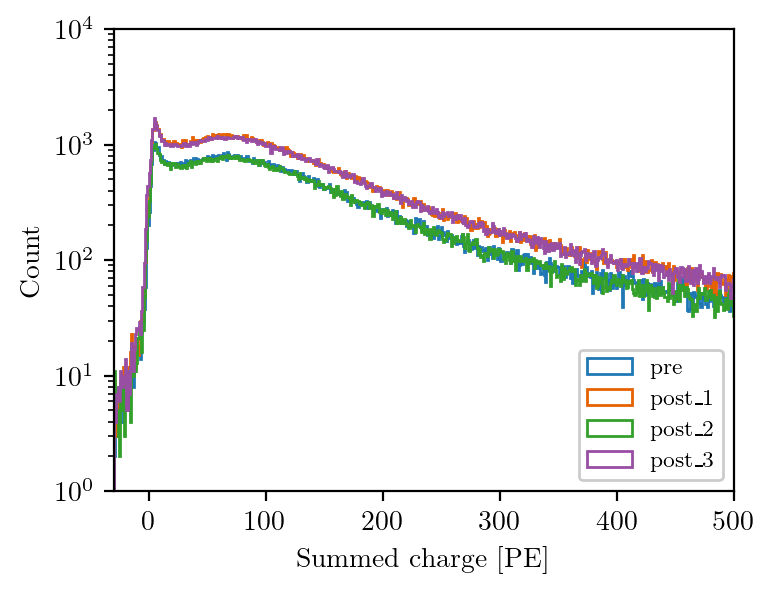

In [5]:
xmin = -30
xmax = 500
nbins = 500
plt.figure()
labels = ['pre', 'post_1', 'post_2', 'post_3']
for i,integral in enumerate(summed_integral_pe_datasets):
    plt.hist(integral, bins=np.linspace(xmin,xmax,nbins), histtype='step', label=labels[i])
plt.yscale('log')
plt.legend(loc='lower right')
plt.xlim(xmin, xmax)
plt.xlabel('Summed charge [PE]')
plt.ylabel('Count')
plt.show()

A=3128.729368813119  TAU=1.222235984585067 us$
A=3055.418138890581  TAU=1.2279838715016376 us$
A=2877.149218112846  TAU=1.2502158195030928 us$
A=2721.438695955876  TAU=1.2692697566870637 us$
A=1015.4898271756853  TAU=1.5813327337986618 us$
A=972.3935736285168  TAU=1.598675745755632 us$
A=932.0048291775638  TAU=1.6281391366330515 us$
A=914.2199812185141  TAU=1.642803800292212 us$
A=2338.324695309287  TAU=1.299396482533339 us$
A=2206.962554604825  TAU=1.316827264912901 us$
A=2107.410373120635  TAU=1.338071432871485 us$
A=2031.8276722157968  TAU=1.3532848448833128 us$
A=1272.8563271684268  TAU=1.4847035832557227 us$
A=1224.719422538032  TAU=1.4992448054576142 us$
A=1165.320658675118  TAU=1.5282419988644018 us$
A=1139.9200920995413  TAU=1.5417941192726514 us$


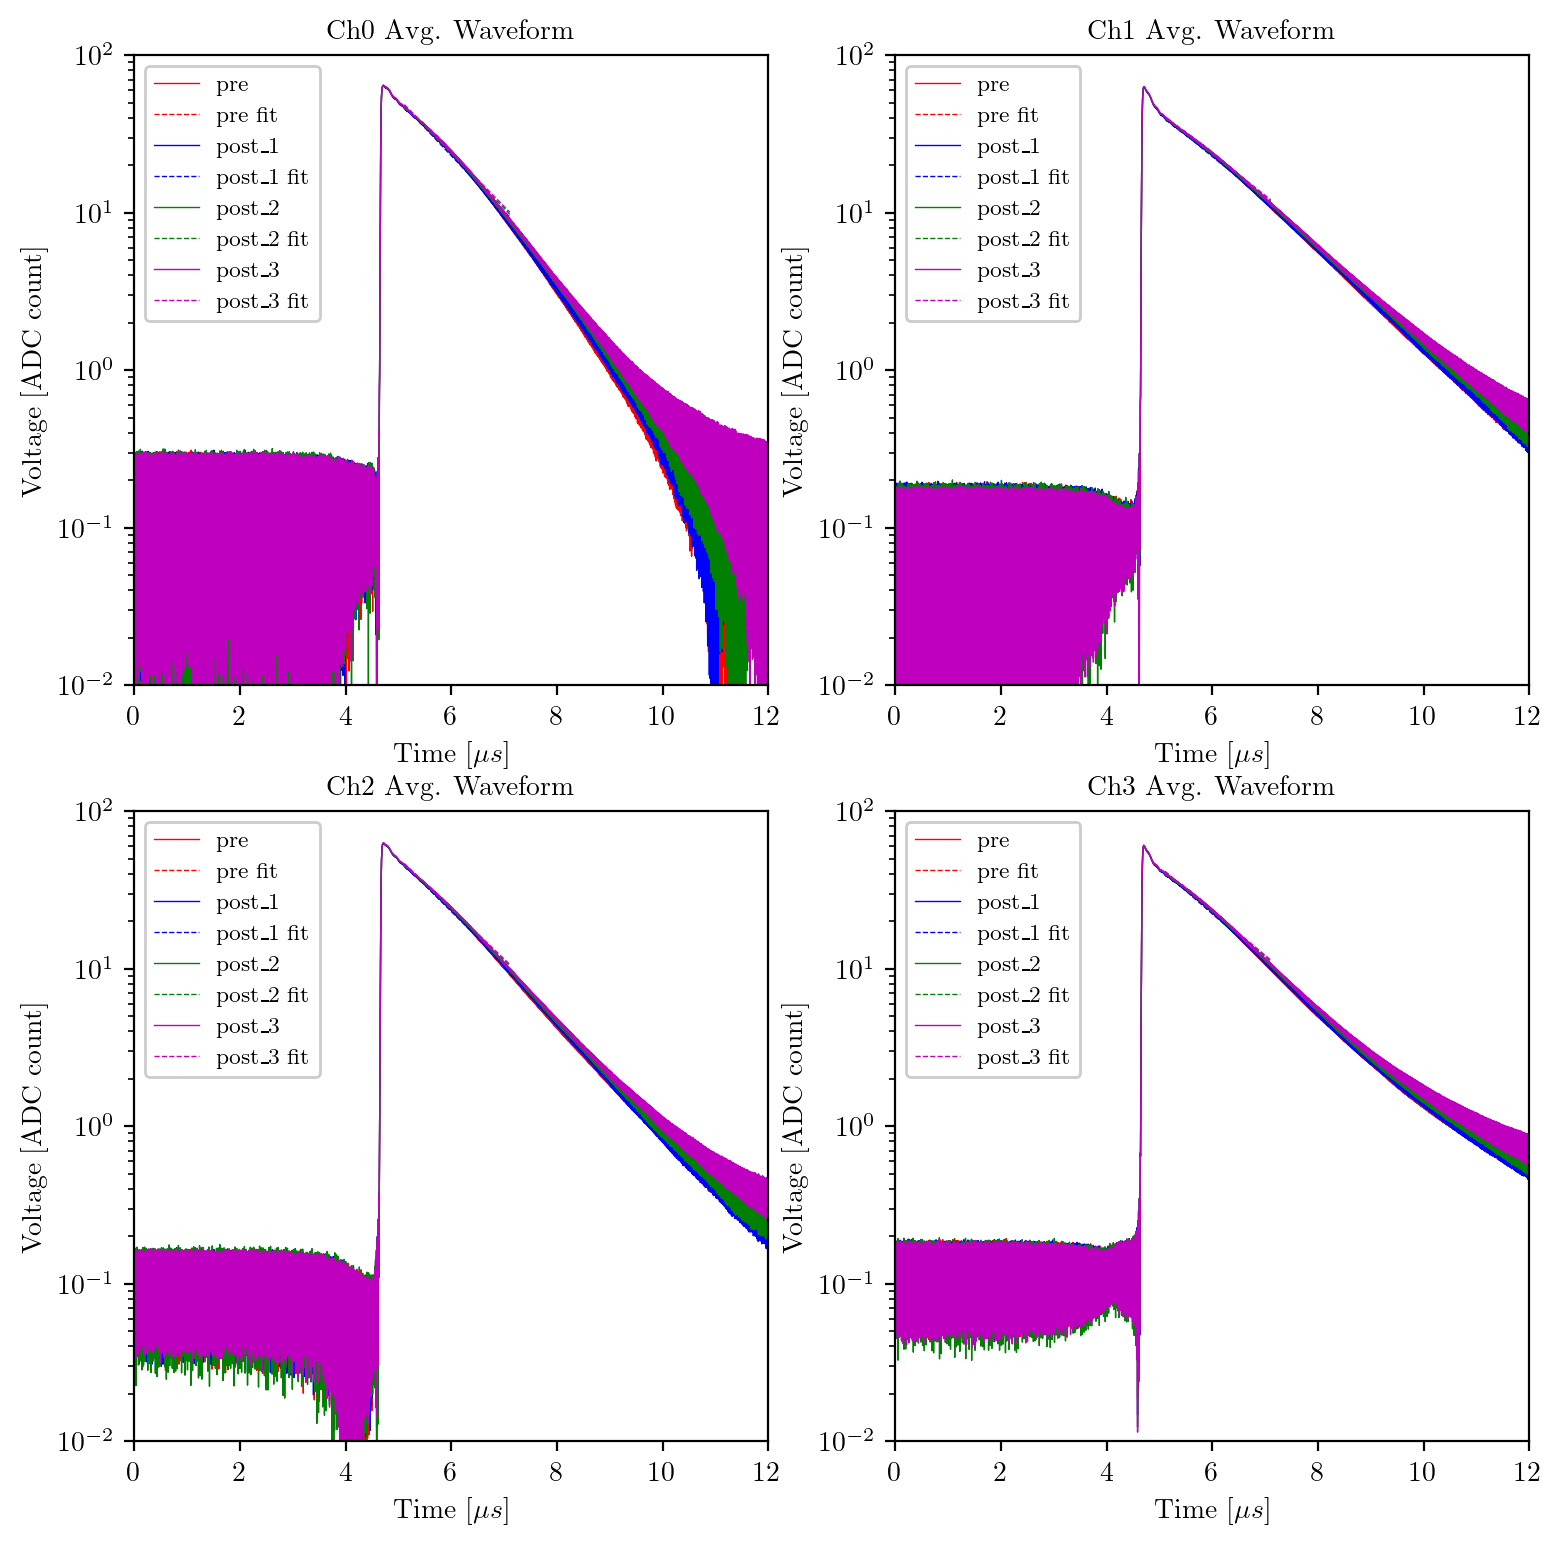

In [13]:
tau_ch_datasets = []
plt.figure(0,figsize=(9,9))
labels = ['pre', 'post_1', 'post_2', 'post_3']
colors = ['r','b','g','m']
for ch in range(4):
    plt.subplot(2,2,ch+1)
    plt.title('Ch{} Avg. Waveform'.format(ch))
    plt.ylabel('Voltage [ADC count]')
    plt.xlabel(r'Time [$\mu s$]')
    tau_datasets = []
    for i,avgwf in enumerate(avgwf_datasets):
        plt.plot(time_datasets[i], abs(avgwf[ch]), "{}-".format(colors[i]), label=labels[i], linewidth=0.5, )
        trig_pos = np.argmax(avgwf[ch])
        trig_height = np.max(avgwf[ch])
        popt,pcov = curve_fit(expo_scint, time_datasets[i][trig_pos+100:trig_pos+600], avgwf[ch][trig_pos+100:trig_pos+600], p0=[trig_height/np.exp(-trig_pos*4e-3/1.5),1.5],maxfev=10000)
        print(r'A={}  TAU={} us$'.format(popt[0],popt[1]))
        tau_datasets.append(popt[1])
        plt.plot(time_datasets[i][trig_pos+100:trig_pos+600], expo_scint(time_datasets[i][trig_pos+100:trig_pos+600], *popt), "{}--".format(colors[i]), label='{} fit'.format(labels[i]), linewidth=0.5)
    tau_ch_datasets.append(tau_datasets)
    plt.legend()
    plt.xlim(0,12)
    plt.ylim(1e-2, 100)
    plt.yscale('log')

# Scintillation data top 1007

In [7]:
data_dir = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/"
subdir = ["2022-10-07/2022-10-07_volt_70_pos_top_light_scint_0/","2022-10-07/2022-10-07_volt_70_pos_top_light_scint_1/","2022-10-07/2022-10-07_volt_70_pos_top_light_scint_2/","2022-10-07/2022-10-07_volt_70_pos_top_light_scint_3/", "2022-10-07/2022-10-07_volt_70_pos_top_light_scint_4/", "2022-10-07/2022-10-07_volt_70_pos_top_light_scint_5/"]

In [8]:
summed_integral_pe_datasets_1007 = []
avgwf_datasets_1007 = []
time_datasets_1007 = []
for subdir_ in subdir:
    avgwf_ch = []
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4))
    for i in range(4):
        print(data.ch[i].file)
        print("Analyzing channel {}".format(i))
        data.ch[i].read_data()
        print("read data")
        data.ch[i].baseline_subtraction()
        print("baseline")
        data.ch[i].get_avg_wf()
        avgwf_ch.append(data.ch[i].avgwf)
        print("average waveform")
        data.ch[i].get_integral()
        print("get_integral")
        data.ch[i].clear()
        print("clear")
        if i==0:
            time_datasets_1007.append(data.ch[i].time)
    avgwf_datasets_1007.append(avgwf_ch)
    data.get_summed_integral_pe()
    summed_integral_pe_datasets_1007.append(data.summed_integral_pe)
    print("summed charge")


/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-07/2022-10-07_volt_70_pos_top_light_scint_0/wave0.dat
Analyzing channel 0
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1180
NUMBER OF WAVEFORMS = 9966
read data
baseline
average waveform
get_integral
clear
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-07/2022-10-07_volt_70_pos_top_light_scint_0/wave1.dat
Analyzing channel 1
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1178
NUMBER OF WAVEFORMS = 9966
read data
baseline
average waveform
get_integral
clear
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-07/2022-10-07_volt_70_pos_top_light_scint_0/wave2.dat
Analyzing channel 2
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1178
NUMBER OF WAVEFORMS = 9966
read data
baseline
average waveform
get_integral
clear
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-07/2022-10-07_volt_70_pos_top_light_scint_0/wave3.dat
Analyzing channel 3
WAVEFORM LENGTH = 3000 SAMPLES
TRIGG

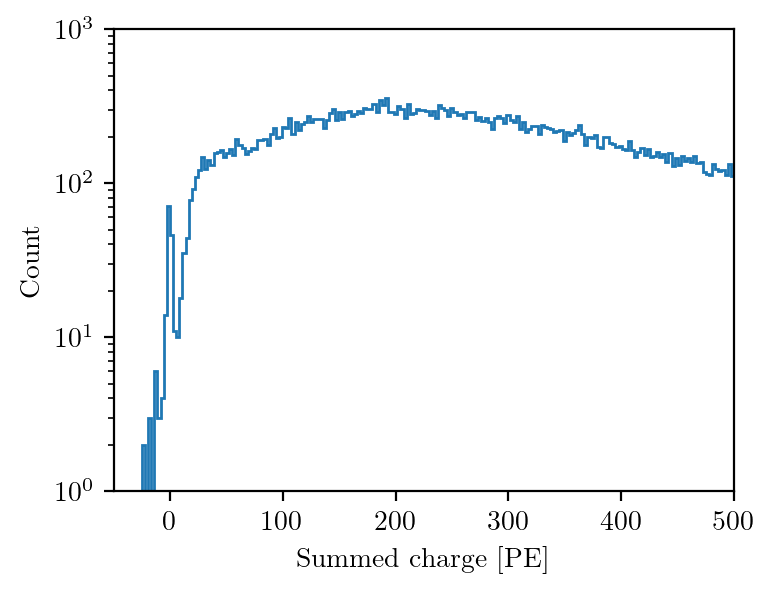

In [9]:
xmin = -50
xmax = 500
nbins = 200
plt.figure()
merge_integral = []
for i,integral in enumerate(summed_integral_pe_datasets_1007):
    merge_integral = merge_integral + list(integral)
plt.hist(merge_integral, bins=np.linspace(xmin,xmax,nbins), histtype='step')
plt.yscale('log')
plt.xlim(xmin, xmax)
plt.xlabel('Summed charge [PE]')
plt.ylabel('Count')
plt.show()

A=3044.0414694276847  TAU=1.5296171985054838 us$
A=1033.61893759277  TAU=2.1058653004894072 us$
A=2268.0120924757393  TAU=1.6582953342436277 us$
A=1295.4883559230736  TAU=1.9500949494011732 us$


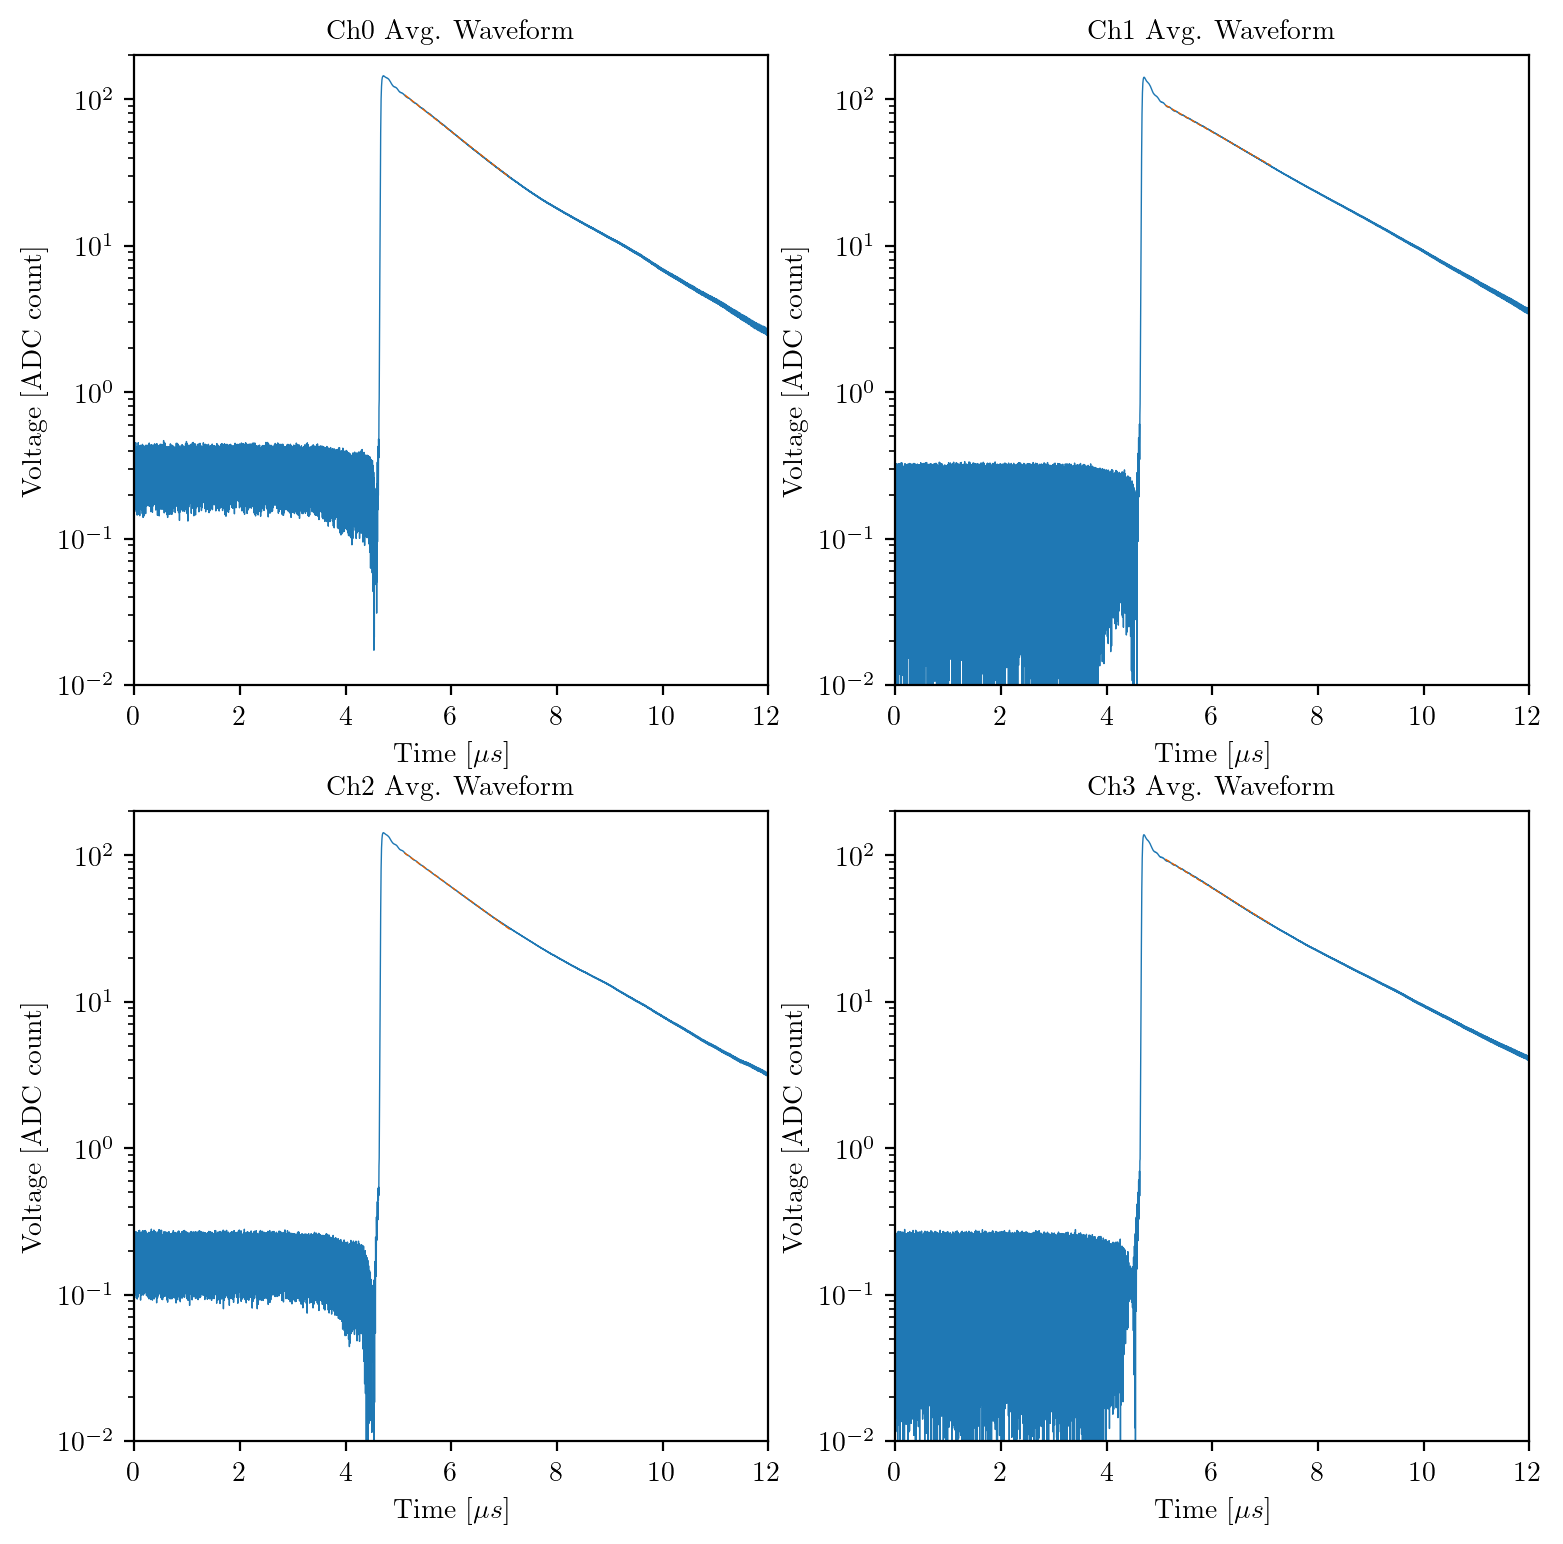

In [14]:
plt.figure(0,figsize=(9,9))
avgwf_overall = np.zeros((4,np.shape(avgwf_datasets_1007)[2]))
for ch in range(4):
    plt.subplot(2,2,ch+1)
    plt.title('Ch{} Avg. Waveform'.format(ch))
    plt.ylabel('Voltage [ADC count]')
    plt.xlabel(r'Time [$\mu s$]')
    for i,avgwf in enumerate(avgwf_datasets_1007):
        avgwf_overall[ch] = np.mean(np.array(avgwf_datasets_1007)[:,ch,:], axis=0)
    plt.plot(time_datasets_1007[0], abs(avgwf_overall[ch]), '-', label = '10-07', linewidth=0.5)
    trig_pos = np.argmax(avgwf_overall[ch])
    trig_height = np.max(avgwf_overall[ch])
    popt,pcov = curve_fit(expo_scint, time_datasets_1007[0][trig_pos+100:trig_pos+600], avgwf_overall[ch][trig_pos+100:trig_pos+600], p0=[trig_height/np.exp(-trig_pos*4e-3/1.5),1.5],maxfev=10000)
    print(r'A={}  TAU={} us$'.format(popt[0],popt[1]))
    tau_ch_datasets[ch].append(popt[1])
    plt.plot(time_datasets_1007[0][trig_pos+100:trig_pos+600], expo_scint(time_datasets_1007[0][trig_pos+100:trig_pos+600], *popt), "--", label='10-07 fit', linewidth=0.5)

    plt.xlim(0,12)
    plt.ylim(1e-2, 200)
    plt.yscale('log')

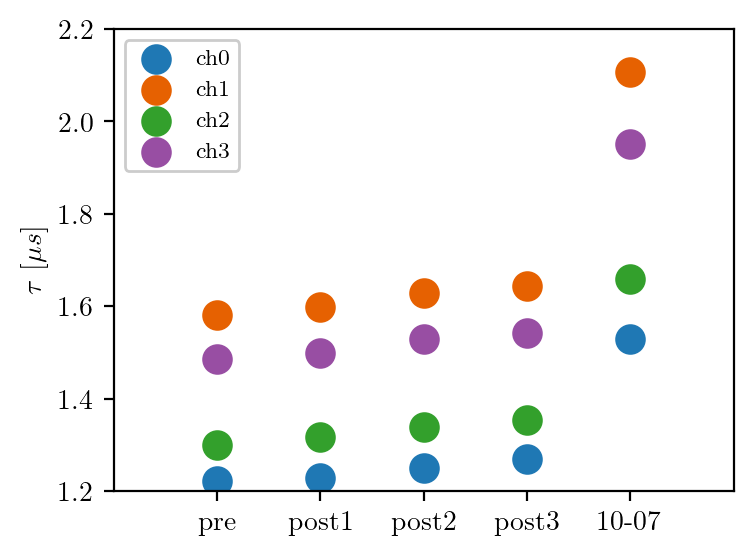

In [15]:
plt.figure()
for ch in range(4):
    plt.scatter(np.arange(len(tau_ch_datasets[ch])), tau_ch_datasets[ch],label='ch{}'.format(ch))
plt.ylabel(r'$\tau~[\mu s]$')
plt.xticks(np.arange(len(tau_ch_datasets[ch])),labels=['pre','post1','post2','post3','10-07'])
plt.xlim(-1,5)
plt.legend()

# Theoretical Beta Spectrum of $^{90}\rm Sr$/$^{90}\rm Y$
$$N(T) = C F(Z,T) pE(Q-T)^2$$
$$Q_{^{90}\rm Sr} = 0.546\rm MeV$$
$$Q_{^{90}\rm Y} = 2.28\rm MeV$$

In [ ]:
Q_SR90 = 0.546e3 #keV
Q_Y90 = 2.28e3 #keV 
ALPHA = 1/137

def Fermi_function(Z: int, T: float) -> float:
    '''
    Z: atomic number
    T: kinetic energy in keV
    '''
    S = np.sqrt(1-(ALPHA*Z)**2)
    rho = 0
    eta = 0
    p = 0
    return 0

def beta_shape_sr90(E: float) -> float:

    return 0